In [1]:
# U-NET CNN Approach to Automated Image Analysis
    # base code from: https://www.kaggle.com/code/vbookshelf/simple-cell-segmentation-with-keras-and-u-net
#-------------------------------------------------------------------------------------------------------------

# Read in libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
# %matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
# warnings.filterwarnings('ignore')

IMG_HEIGHT =  1000#1040 # 128
IMG_WIDTH = 1000#1040#1388 # 128
IMG_CHANNELS = 3 # RGB, remove green later

NUM_TEST_IMAGES = 2


In [2]:
mother_directory = "../../data/test_images/" # contains 15 images used for binary_masks plus 13 others
    # home of analyzed output images & csvs
child_directory_image = "ML_output/images/"
child_directory_csv = "ML_output/csvs/"


if not os.path.isdir(child_directory_csv):
    os.mkdir(child_directory_csv)
if not os.path.isdir(child_directory_image):
    os.mkdir(child_directory_image)

#-------------------------------------------------------------------------------------------------------------

# get a list of files in each folder
mask_dir = "../../data/outlines/"

img_list = os.listdir(mother_directory)
img_list=[val for val in img_list if val.endswith(".jpg")]
mask_list = os.listdir(mask_dir)
mask_list=[val for val in mask_list if val.endswith(".jpg")]

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

df_images

,image_id
0,AS_A_I_15_4-20240720.jpg
1,AS_A_I_22_4-20240718.jpg
2,AS_A_I_22_5-20240718.jpg
3,AS_B_I_15_4-20240724.jpg
4,AS_B_I_22_5-20240720.jpg
5,AS_B_I_22_6-20240717.jpg
6,AS_B_U_15_1-20240726.jpg
7,AS_C_I_15_2-20240726.jpg
8,AS_C_I_15_3-20240724.jpg
9,AS_C_U_15_3-20240717.jpg


In [3]:
# ================================================
# Add a column indicating if an image has a mask.
# ================================================

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    x=x.replace(".jpg",".jpg")
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)
df_images

,image_id,has_mask
0,AS_A_I_15_4-20240720.jpg,no
1,AS_A_I_22_4-20240718.jpg,no
2,AS_A_I_22_5-20240718.jpg,no
3,AS_B_I_15_4-20240724.jpg,no
4,AS_B_I_22_5-20240720.jpg,no
5,AS_B_I_22_6-20240717.jpg,no
6,AS_B_U_15_1-20240726.jpg,no
7,AS_C_I_15_2-20240726.jpg,no
8,AS_C_I_15_3-20240724.jpg,no
9,AS_C_U_15_3-20240717.jpg,no


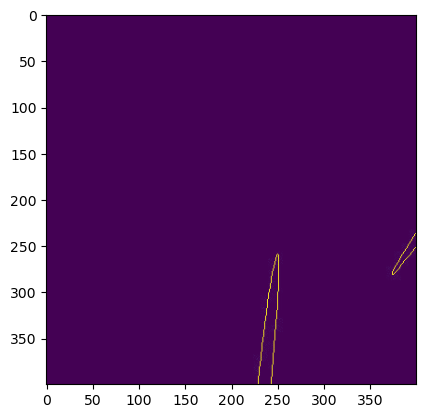

In [4]:
plt.imshow(imread("../../data/outlines/THN_A_I_15_1-20240717.jpg")[0:400,0:400])

In [5]:
# ===========================================================
# subset to only masks
# ===========================================================

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = [val for val in df_masks['image_id']]

df_masks.shape

C:\Users\Rayna\AppData\Local\Temp\ipykernel_13736\2246204734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = [val for val in df_masks['image_id']]


(12, 3)

In [6]:
# ===========================================================
# Create a test set
# ===========================================================

# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(10, 3)
(2, 3)


In [7]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), 1040,1388,3), dtype=np.uint8)
Y_train = np.zeros((len(image_id_list), 1040,1388), dtype=bool)
X_test = np.zeros((NUM_TEST_IMAGES, 1040,1388, IMG_CHANNELS), dtype=np.uint8)

# X_train


for i, image_id in enumerate(image_id_list):
    path_image = mother_directory + image_id
    
    # read the image using skimage
    image = imread(path_image)
    '''red_channel = np.copy(image[:, :, 0])
    blue_channel = np.copy(image[:, :, 2])
    grayscale_image=np.zeros((len(red_channel),len(red_channel[0])))
    for x in range(len(red_channel)):
        for y in range(len(red_channel[0])):
            grayscale_image[x,y]=max(red_channel[x,y],blue_channel[x,y])'''
    image=imread(path_image)
    # resize the image
    #image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    #image = np.expand_dims(image, axis=-1)
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(10, 1040, 1388, 3)

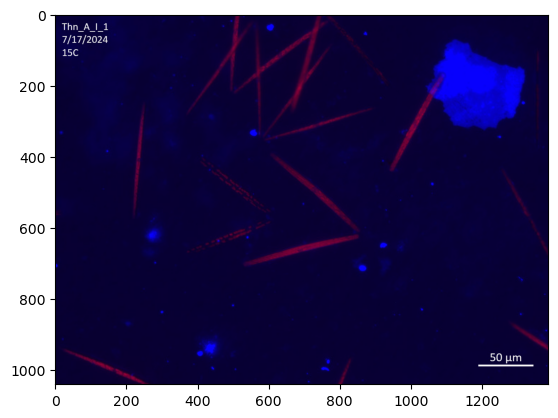

In [8]:
plt.imshow(X_train[0])

In [9]:
Y_train=[]
for i, mask_id in enumerate(mask_id_list):
    
    path_mask =mask_dir + mask_id
    print(path_mask)
    # read the image using skimage
    mask = imread(path_mask)#binary masks are 0 or 255 for all 3 channels so we can take any channel
    
    # resize the image
    #mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    #mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train.append(mask)
Y_train=np.array(Y_train)
Y_train.shape

../../data/outlines/THN_A_I_15_1-20240717.jpg
../../data/outlines/THN_A_I_15_1-20240724.jpg
../../data/outlines/THN_A_I_22_3-20240724.jpg
../../data/outlines/THN_B_I_15_5-20240726.jpg
../../data/outlines/THN_C_I_15_3-20240724.jpg
../../data/outlines/THN_C_I_15_4-20240720.jpg
../../data/outlines/THN_C_I_22_2-20240720.jpg
../../data/outlines/THN_Starter_2-20240711.jpg
../../data/outlines/THN_STARTER_4-20240716.jpg
../../data/outlines/THN_Starter_5-20240711.jpg


(10, 1040, 1388)

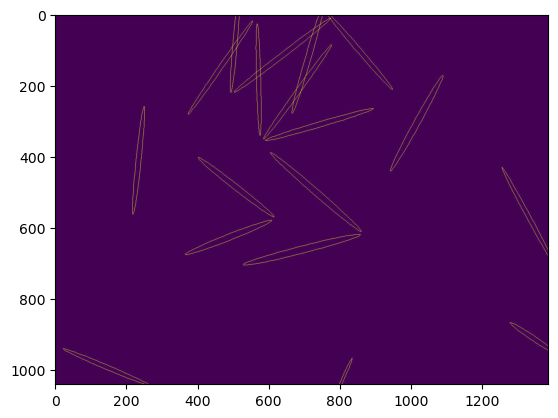

In [10]:
plt.imshow(Y_train[0])

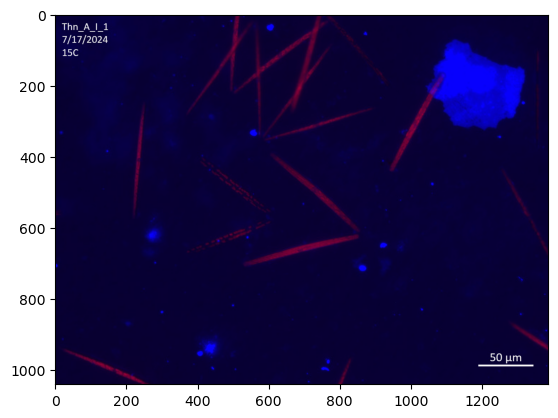

In [11]:
plt.imshow(X_train[0])

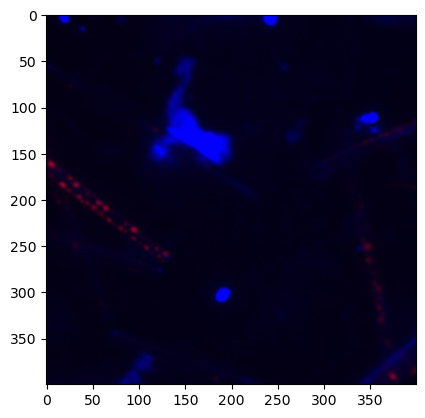

In [12]:
tiled_x_train,tiled_y_train=[],[]

'''for X,y in zip(X_train,Y_train):
    for y_pos in range(0,700,100):
        for x_pos in range(0,400,100):
            tiled_x_train.append(X[x_pos:x_pos+600,y_pos:y_pos+600])
            tiled_y_train.append(y[x_pos:x_pos+600,y_pos:y_pos+600])'''

for X,y in zip(X_train,Y_train):
    for y_pos in range(0,900,100):
        for x_pos in range(0,600,100):
            tiled_x_train.append(X[x_pos:x_pos+400,y_pos:y_pos+400])
            tiled_y_train.append(y[x_pos:x_pos+400,y_pos:y_pos+400])
            
plt.imshow(tiled_x_train[-1])

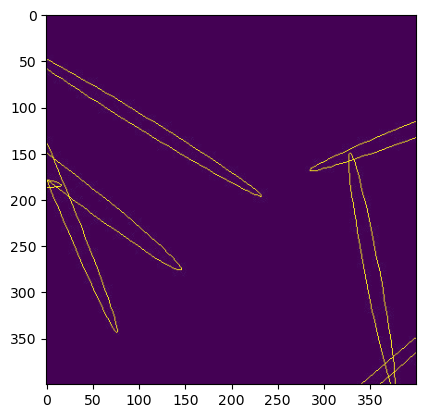

In [13]:
plt.imshow(tiled_y_train[-1])

In [14]:
X.shape

(1040, 1388, 3)

In [15]:
len(tiled_x_train)

540

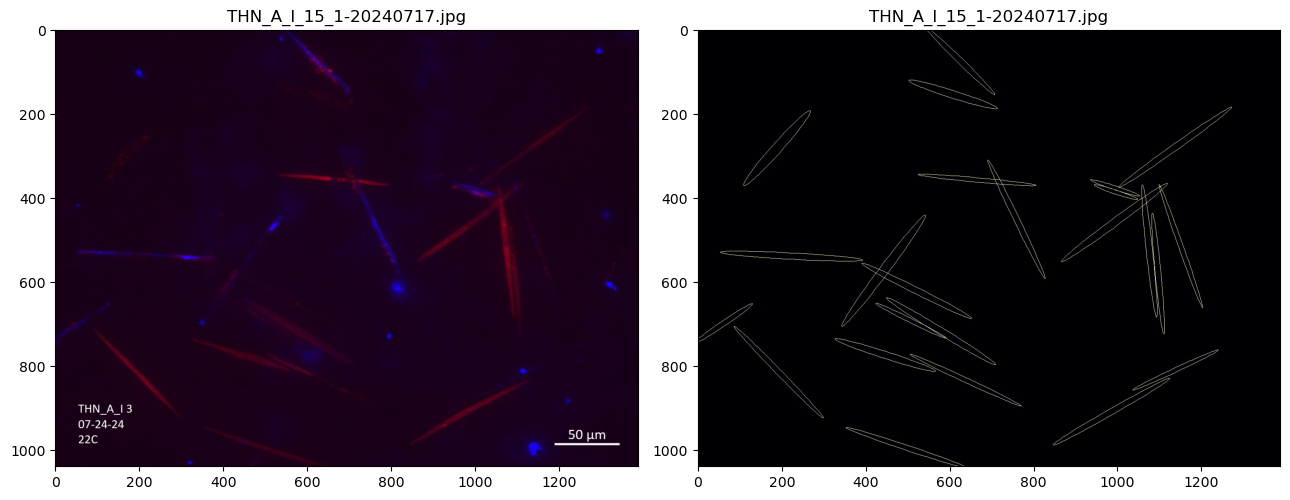

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
ax[0].imshow(X_train[2], cmap='magma')
ax[1].imshow(Y_train[2], cmap='magma')
ax[0].set_title(image_id_list[0])
ax[1].set_title(mask_id_list[0])
fig.tight_layout()

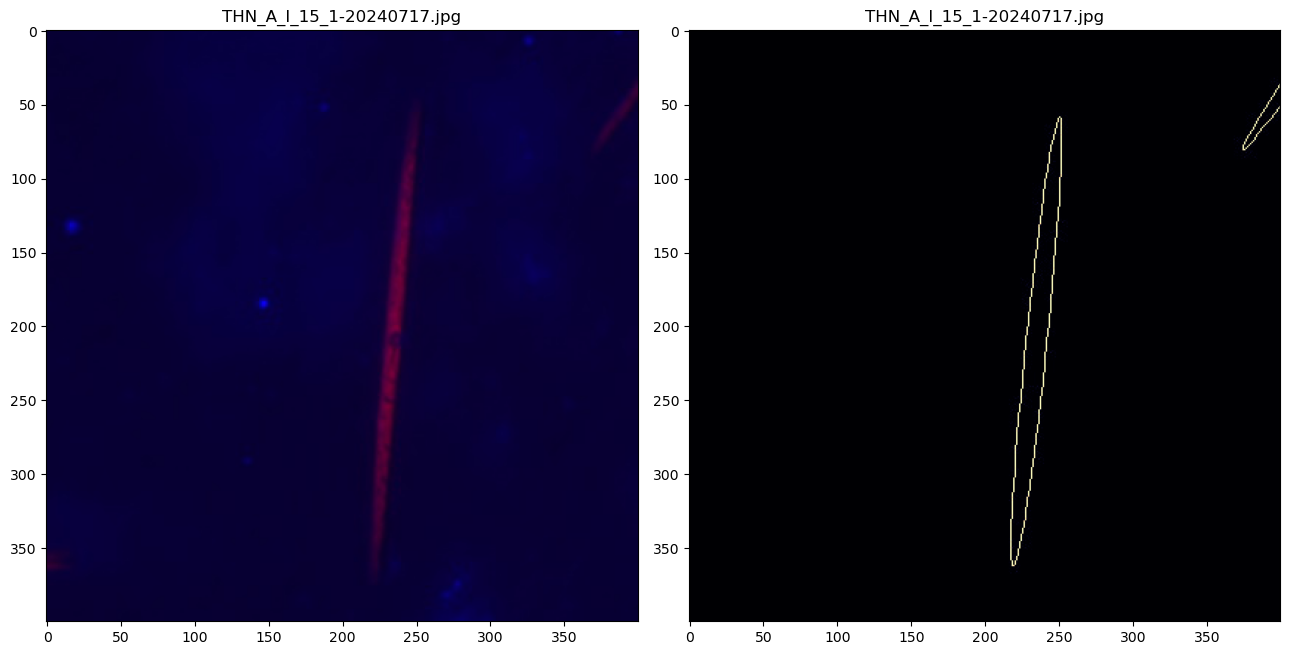

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
ax[0].imshow(tiled_x_train[2], cmap='magma')
ax[1].imshow(tiled_y_train[2], cmap='magma')
ax[0].set_title(image_id_list[0])
ax[1].set_title(mask_id_list[0])
fig.tight_layout()

In [18]:
X.shape

(1040, 1388, 3)

In [19]:
augmented_X_train,augmented_y_train=[],[]

for X,y in zip(tiled_x_train,tiled_y_train):
    augmented_X_train.append(X)
    augmented_y_train.append(y)

for X,y in zip(tiled_x_train,tiled_y_train):
    augmented_X_train.append(np.rot90(X))
    augmented_y_train.append(np.rot90(y))

for X,y in zip(tiled_x_train,tiled_y_train):
    augmented_X_train.append(np.fliplr(X))
    augmented_y_train.append(np.fliplr(y))

for X,y in zip(tiled_x_train,tiled_y_train):
    augmented_X_train.append(np.rot90(X,k=2))
    augmented_y_train.append(np.rot90(y,k=2))

for X,y in zip(tiled_x_train,tiled_y_train):
    augmented_X_train.append(np.flipud(X))
    augmented_y_train.append(np.flipud(y))

for X,y in zip(tiled_x_train,tiled_y_train):
    augmented_X_train.append(np.rot90(X,k=3))
    augmented_y_train.append(np.rot90(y,k=3))


augmented_X_train,augmented_y_train=np.array(augmented_X_train),np.array(augmented_y_train)
augmented_X_train.shape

(3240, 400, 400, 3)

In [20]:
augmented_y_train.shape

(3240, 400, 400)

In [21]:

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [49]:
IMG_CHANNELS=3
inputs = Input((400,400, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy',loss_weights=[1,1000])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 400, 400, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 400, 400, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [50]:
normalized_y_train=augmented_y_train/255

In [51]:

# ===========================================================
# Train the model
# ===========================================================

filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(augmented_X_train, normalized_y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)


Epoch 1/50
183/183 [==============================] - ETA: 0s - loss: 0.0645   
Epoch 1: val_loss improved from inf to 0.05973, saving model to model.h5
183/183 [==============================] - 441s 2s/step - loss: 0.0645 - val_loss: 0.0597
Epoch 2/50
183/183 [==============================] - ETA: 0s - loss: 0.0430  
Epoch 2: val_loss improved from 0.05973 to 0.05091, saving model to model.h5
183/183 [==============================] - 433s 2s/step - loss: 0.0430 - val_loss: 0.0509
Epoch 3/50
  4/183 [..............................] - ETA: 7:05 - loss: 0.0461

KeyboardInterrupt: 

In [52]:
model.load_weights('model.h5')


In [53]:
in_sample_prediction=model.predict(augmented_X_train)

102/102 [==============================] - 79s 769ms/step


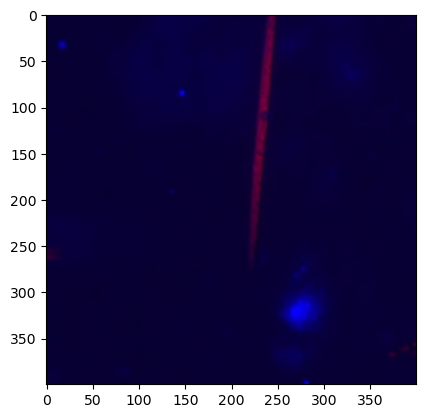

In [54]:
plt.imshow(augmented_X_train[3])

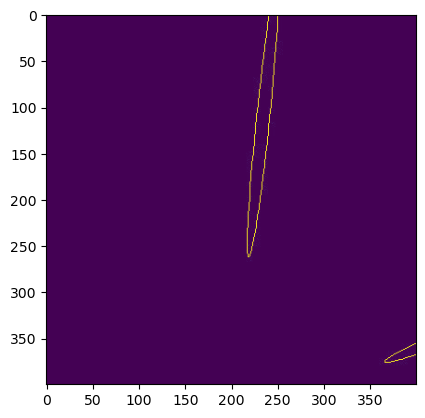

In [55]:
plt.imshow(augmented_y_train[3])

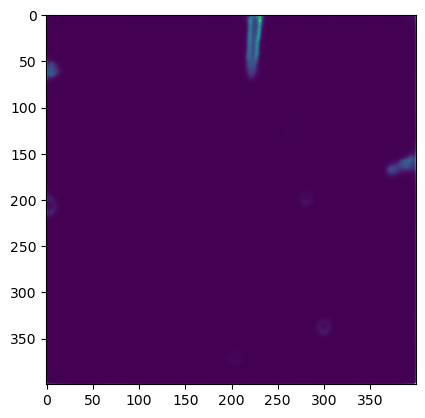

In [56]:
plt.imshow(in_sample_prediction[5])

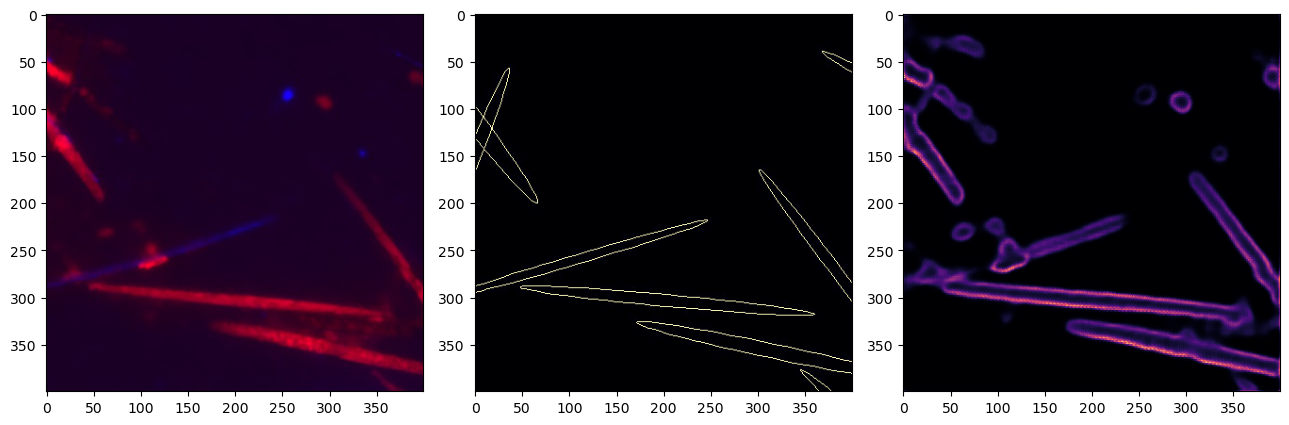

In [121]:
num=300
fig, ax = plt.subplots(1, 3, figsize=(13, 10))
ax[0].imshow(augmented_X_train[num], cmap='magma')
ax[1].imshow(augmented_y_train[num], cmap='magma')
ax[2].imshow(in_sample_prediction[num], cmap='magma')
fig.tight_layout()

In [ ]:
predictions=model.predict(X_test)

In [ ]:
plt.imshow(X_test[0])

In [ ]:
plt.imshow(predictions[0])

In [ ]:
plt.imshow(predictions[0]>=0.7)

In [ ]:
plt.imshow(predictions[0]>=0.95)